In [14]:
%load_ext autoreload
%autoreload 1

import os
from pathlib import Path
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

%aimport modules
from modules.DataScienceBowl import DataScienceBowl
from modules.Trainer import Trainer
from modules.CustomUnet import CustomUnet
from modules.denseCL.DenseCL import DenseCL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    torch.device('cpu')
    print('using cpu')
    
# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [20]:
# Load data and split into train and test

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()
N = len(indices)
# [ 0.3 train | 0.1 test | 0.1 validate | 0.5 unlab ]
# train_test, test_val, val_unlab = map(int, (0.3 * N, 0.4 * N, 0.5 * N))

# [ 0.2 train | 0.05 test | 0.05 validate | 0.7 unlab ]
train_test, test_val, val_unlab = map(int, (0.2 * N, 0.25 * N, 0.3 * N))

train_dataset = torch.utils.data.Subset(dataset, indices[:train_test])
test_dataset = torch.utils.data.Subset(dataset, indices[train_test:test_val])
val_dataset = torch.utils.data.Subset(dataset, indices[test_val:val_unlab])
unlabeled_dataset = torch.utils.data.Subset(dataset, indices[val_unlab:])


BATCH_SIZE = 8
dataLoader_training = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_unlabeled = DataLoader(dataset=unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_validation = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
def store_train(train_result, hyper_params):
    
    train_loss, val_loss, val_iou, test_loss, test_iou = train_result
    init, lr, wd = hyper_params
    
    RESULTS_DIR = 'results/'
    file = f'baseline_train_results_lr-{lr}_init-{init}_wd-{wd}.pk'
    CUR_DIR = os.getcwd()
    FILE_PATH = os.path.join(CUR_DIR, RESULTS_DIR, file)
    print(f'Storing train results in {FILE_PATH}')
    
    dump_dict = {'results': train_result, 'hyper_params': hyper_params}
    
    with open(FILE_PATH, 'wb') as file:
        pickle.dump(dump_dict, file)



Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-12_init-12_wd-12.pk


In [21]:
baseline_hyper_params = {
    'init': ["imagenet", "random"],
    'lr': [0.01, 0.001],
    'weight_decay': [0, 0.0001],
}

for init in baseline_hyper_params['init']:
    for lr in baseline_hyper_params['lr']:
        for wd in baseline_hyper_params['weight_decay']:

            if init == 'random':
                # Random weights
                encoder = DenseCL().encoder
                model = CustomUnet(encoder)
            else:
                # Imagenet weights
                model = CustomUnet()

            model.to(device)


#             model = CustomUnet().to(device)
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr, wd)

            trainer = Trainer(model=model,
                             device=device,
                             criterion=criterion,
                             optimizer=optimizer,
                             training_DataLoader=dataLoader_training,
                             validation_DataLoader=dataLoader_validation,
                             test_DataLoader=dataLoader_test,
                             epochs=20,
                             notebook=True,
                             seed=42)

            train_result = trainer.run_trainer()
            
            print(f'finished training for lr:{lr}, wd:{wd}, init:{init} with test IoU: {train_result[-1]}')
            
            store_train(train_result, (init, lr, wd))

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.01, wd:0, init:imagenet with test IoU: 0.6533603441383465
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.01_init-imagenet_wd-0.pk


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.01, wd:0.0001, init:imagenet with test IoU: 0.6894789899986588
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.01_init-imagenet_wd-0.0001.pk


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.001, wd:0, init:imagenet with test IoU: 0.0769836135554699
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.001_init-imagenet_wd-0.pk


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.001, wd:0.0001, init:imagenet with test IoU: 0.07671352852631949
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.001_init-imagenet_wd-0.0001.pk
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.01, wd:0, init:random with test IoU: 0.7092291230014941
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.01_init-random_wd-0.pk
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.01, wd:0.0001, init:random with test IoU: 0.6998445596367249
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.01_init-random_wd-0.0001.pk
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.001, wd:0, init:random with test IoU: 0.5022831034540426
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.001_init-random_wd-0.pk
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

finished training for lr:0.001, wd:0.0001, init:random with test IoU: 0.48373539061764576
Storing train results in C:\Users\Harm\Documents\Uni\MasterThesis\MscThesis\results/baseline_train_results_lr-0.001_init-random_wd-0.0001.pk


In [14]:
print(test_iou)

0.6218400838039375


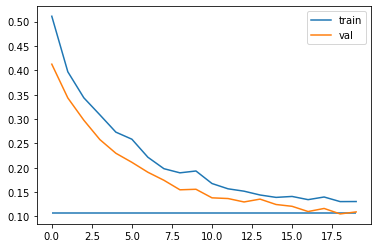

In [16]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.hlines(test_loss, 0, len(train_loss) - 1)
plt.legend()
plt.show()

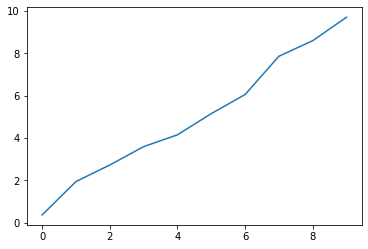

In [17]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

vals = []
for i in range(10):
    pl.clf()
    vals.append(i+pl.rand())
    pl.plot(vals)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.2)